In [22]:
import pandas as pd
import numpy as np
import os

df = pd.read_csv('/home/martin/projects/hpa_image_analysis/data/colon_enhanced.csv')
df['tissue_type'] = df.apply(lambda row: row['s3_aws_urls'].split('/')[6], axis=1)
# df = df[df['tissue_type']=='pathology_tissue']
df = df[['s3_aws_urls', 'subcellular_location', 'tissue_type']].sample(10000)
df['filename'] = df.apply(lambda row: row['s3_aws_urls'].split('/')[9], axis=1)

file_list = os.listdir('/data/hpa/colon/embeddings')
df['embedding'] = df.apply(lambda row: np.load('/data/hpa/colon/embeddings/{}.npy'.format(row['filename'].split('.')[0]))
                           if row['filename'].split('.')[0]+'.npy' in file_list else np.nan, axis=1)

In [17]:
import sklearn.manifold
import time
import numpy as np

df = df.dropna()

start_time = time.time()

tsne = sklearn.manifold.TSNE(n_components=2, perplexity=30)
tsne_table = tsne.fit_transform(np.stack(df['embedding'].values))
np.save('colon_all_embedding_tsne.npy', tsne_table)

print('time taken: ', time.time() - start_time)




time taken:  266.2083685398102


In [3]:
tsne_table = np.load('colon_all_embedding_tsne.npy')
tsne_df = pd.DataFrame(tsne_table, columns=['tsne0', 'tsne1'])

In [18]:
tsne_df = pd.DataFrame(tsne_table, columns=['tsne0', 'tsne1'])

In [19]:
tsne_df = pd.concat([tsne_df, df[['tissue_type', 'filename', 's3_aws_urls', 'subcellular_location']].reset_index()], axis=1).drop(columns='index')

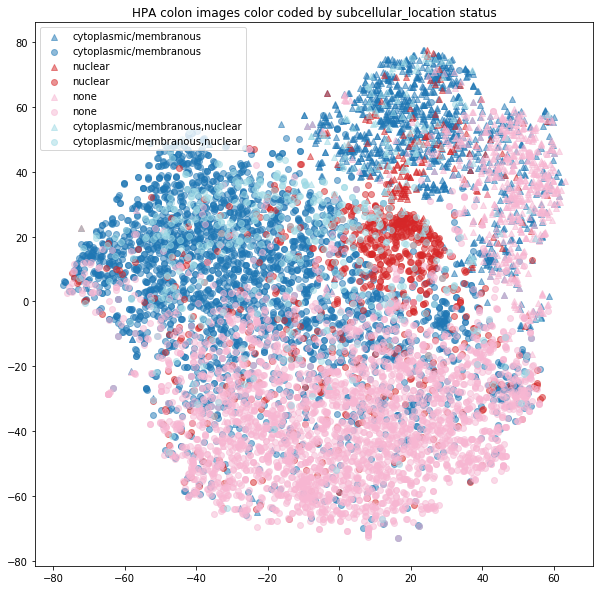

In [21]:
import matplotlib.pyplot as plt

color_var = 'subcellular_location'
labels = list(tsne_df[color_var].unique())
cmap = plt.get_cmap('tab20')
colors = cmap(np.linspace(0, 1, len(labels)))

plt.figure(figsize=(10,10))

for i, (label, color) in enumerate(zip(labels, colors), 1):
    plt.scatter(tsne_df[(tsne_df[color_var]==label)&(tsne_df['tissue_type']=='healthy_tissue')]['tsne0'], tsne_df[(tsne_df[color_var]==label)&(tsne_df['tissue_type']=='healthy_tissue')]['tsne1'], label=label, c=[color], alpha=0.5, marker='^')
    plt.scatter(tsne_df[(tsne_df[color_var]==label)&(tsne_df['tissue_type']=='pathology_tissue')]['tsne0'], tsne_df[(tsne_df[color_var]==label)&(tsne_df['tissue_type']=='pathology_tissue')]['tsne1'], label=label, c=[color], alpha=0.5, marker='o')
    #plt.scatter(tsne_df[tsne_df[color_var]==label]['tsne0'], tsne_df[tsne_df[color_var]==label]['tsne1'], label=label, c=[color], alpha=0.5, marker='o')
plt.legend()
plt.title('HPA colon images color coded by '+ color_var+ ' status')
plt.show()